# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

import cufflinks
cufflinks.go_offline(connected = True)
init_notebook_mode(connected = True)

import string
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold,train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb
import re

In [ ]:
!ls ../input/product-category-from-invoice/88b2c062-9-dataset/Dataset/

# Loading dataset

In [ ]:
df_train = pd.read_csv("../input/product-category-from-invoice/88b2c062-9-dataset/Dataset/Train.csv")
df_test = pd.read_csv("../input/product-category-from-invoice/88b2c062-9-dataset/Dataset/Test.csv")

In [ ]:
df_train.shape, df_test.shape

In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [ ]:
df_train.head()

# Exploratory data analysis

In [ ]:
df_train['Product_Category'].iplot(kind='hist', yTitle ='count', title = 'Product Category Distribution', color = 'rgb(120,130,140)')

We could see that the class distribution is uneven. 

In [ ]:
df_train['Product_Category'].value_counts()

In [ ]:
## code for comparing distribution of a column in both train and test dataset
def draw_distribution(train_df, test_df, feature_name, top_counts=None):
    _tmp_material = (train_df[feature_name].value_counts() /train_df.shape[0] * 100) [:top_counts]
    tmp_trace = go.Bar(
                x=_tmp_material.index,
                y=_tmp_material.values,
                name='training_dataset',
            )

    _tmp_material_test = (test_df[feature_name].value_counts() / test_df.shape[0] * 100) [:top_counts]
    tmp_trace_test = go.Bar(
                x=_tmp_material_test.index,
                y=_tmp_material_test.values,
                name='test_dataset'
            )

    layout = go.Layout(
            barmode='group',
            title= " Train/Test " + feature_name + " distribution",
            yaxis=dict(
                title='Counts',
            ),
#             xaxis=dict(
#                 title=feature_name,
#             )

        )

    fig = go.Figure(data=[tmp_trace, tmp_trace_test], layout=layout)
    iplot(fig)

In [ ]:
draw_distribution(df_train, df_test, 'GL_Code')

Distribution of GL_Code is pretty much same in both train and test dataset

In [ ]:
print("Number of unique GL_Code in training dataset", df_train['GL_Code'].nunique())
print("Number of unique GL_Code in test dataset", df_test['GL_Code'].nunique())

In [ ]:
# Vendor code distribution
draw_distribution(df_train, df_test, 'Vendor_Code', 75)

From above plot, some of the vendor codes from train dataset are missing in test and viceversa

In [ ]:
print("Number of unique Vendor_Code in training dataset", df_train['Vendor_Code'].nunique())
print("Number of unique Vendor_Code in test dataset", df_test['Vendor_Code'].nunique())

In [ ]:
# Viewing Invoice amount distribution
hist_data = [df_train['Inv_Amt'], df_test['Inv_Amt']]
group_labels = ['training','testing'] # name of the dataset
fig = ff.create_distplot(hist_data, group_labels, show_hist = False)
fig.show()


AS we can see in above plot, the distribution of Invoice Amount is uniform and the probability of occurance of any value is almost equal which indicates this column doesn't add much value to our analysis

# Missing Values

In [ ]:
df_train.isnull().sum()

In [ ]:
df_test.isnull().sum()

There are no missing values in train and test dataset

# Numerical encoding of categorical features, GL_Code and Vendor_Code

In [ ]:
for col in ['GL_Code','Vendor_Code']:
    le = LabelEncoder()
    le.fit(list(df_train[col])+ list(df_test[col]))
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

# Creating feature matrix X and target y:

In [ ]:
X = df_train.drop(['Product_Category'], axis = 1)
y = df_train['Product_Category']
target = LabelEncoder()
y_encoded = target.fit_transform(y)

 # Model_1 with selected features:
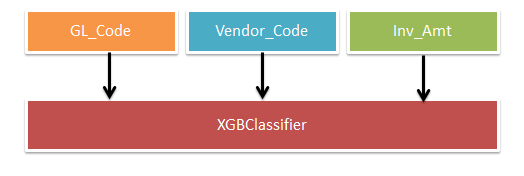


In [ ]:
selected_features = ['GL_Code', 'Vendor_Code', 'Inv_Amt']


In [ ]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(X[selected_features], y_encoded, test_size = 0.3, random_state = 1)

In [ ]:
# parameters for xgboost

param = {}
# use softmax multi-class classification
param['objective']= 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 6
param['silent']=1
param['nthread'] = 4
param['num_class'] = len(target.classes_)
param['eval_metric'] = ['mlogloss']
param['seed'] = 1

In [ ]:
dtrain = xgb.DMatrix(X_train.values, label = y_train)
dvalid = xgb.DMatrix(X_valid.values, label = y_valid)
evallist = [(dtrain,'train'), (dvalid, 'valid')]

In [ ]:
clf = xgb.train(param, dtrain, 100, evallist, verbose_eval = 50)

In [ ]:
y_pred_valid = clf.predict(dvalid)
print("Accuracy:", accuracy_score(y_valid, np.argmax(y_pred_valid,axis =1)))

In [ ]:
xgb.plot_importance(clf, importance_type='gain')

The 3 features used are GL_Code, Vendor_Code and Inv_Amt. As expected, Inv_Amt has very low importance as it is uniformly distributed and not adding much value

In [ ]:
# checking performance in test dataset
dtest= xgb.DMatrix(df_test[selected_features].values)
y_test_pred = clf.predict(dtest)

In [ ]:
output = df_test[['Inv_Id']].copy()
output['Product_Category'] = target.inverse_transform(np.argmax(y_test_pred, axis = 1))

In [ ]:
output.head()

In [ ]:
print("Total Product Categories : {}, Predicted Product Categories : {}".format(len(target.classes_), output.Product_Category.nunique()))

In [ ]:
output.to_csv("./product_category_submission_selected_features.csv", index=False)

# Model 2 (BOW Features):

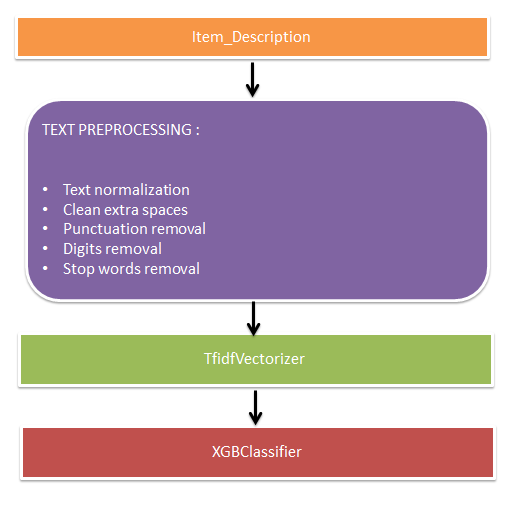

In [ ]:
stop_words = set(stopwords.words('english'))

def tokenize(text):
    '''
        Input: text
        Returns: clean tokens
        Desc:
            Generates a clean token of text (words) by first getting words from the text.
            Normalize the text by lowering it and removes the extra spaces, punctuation and stopwords.
    '''    
    txt =re.sub("[^A-Za-z]+"," ",text)
    tokens = txt.split()
    
    clean_tokens = []
    for tok in tokens:
        if tok not in string.punctuation and tok not in stop_words:
            clean_tokens.append(tok.lower().strip())
    
    return clean_tokens
        

In [ ]:
tfidf = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2), use_idf = False, max_features = None)


In [ ]:
tfidf.fit(X['Item_Description'])

In [ ]:
X_bow = tfidf.transform(X['Item_Description'])
XTest_bow = tfidf.transform(df_test['Item_Description'])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_bow, y_encoded, test_size = 0.3, random_state=1)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

evallist = [(dtrain, 'train'), (dvalid, 'eval')]

clf = xgb.train(param, dtrain, 100, evallist, verbose_eval=50)

In [ ]:
y_pred_valid = clf.predict(dvalid)

print("Accuracy : ",accuracy_score(y_valid, np.argmax(y_pred_valid, axis=1)))

In [ ]:
dtest = xgb.DMatrix(XTest_bow)
y_test_pred = clf.predict(dtest)

In [ ]:
output['Product_Category'] = target.inverse_transform(np.argmax(y_test_pred, axis=1))

In [ ]:
print("Total Product Categories : {0} | predicted categories: {1} "
    .format(len(target.classes_), output['Product_Category'].nunique()))

In [ ]:
output.to_csv("./product_category_submission_bow_features.csv", index=False)

# Model 3 (OOF Prediction):

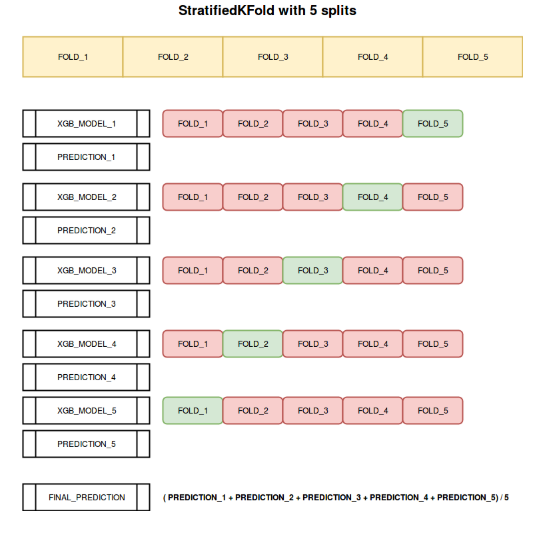

In [ ]:
num_splits = 5
skf = StratifiedKFold(n_splits = num_splits, random_state =1, shuffle = True)

In [ ]:
y_test_pred = np.zeros((df_test.shape[0], len(target.classes_)))
print(y_test_pred.shape)
y_valid_scores =[]
X = df_train['Item_Description']
fold_cnt = 1
dtest = xgb.DMatrix(XTest_bow)

for train_index, valid_index in skf.split(X, y_encoded):
    print("\n Fold...", fold_cnt)
    fold_cnt +=1
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y_encoded[train_index], y_encoded[valid_index]
    
    X_train_bow = tfidf.transform(X_train)
    X_valid_bow = tfidf.transform(X_valid)
    
    dtrain = xgb.DMatrix(X_train_bow, label = y_train)
    dvalid = xgb.DMatrix(X_valid_bow, label = y_valid)
    
    evallist = [(dtrain,'train'), (dvalid,'valid')]
    clf = xgb.train(param, dtrain, 100, evallist, verbose_eval = 50)
    
    # Predicting on validation data
    y_pred_valid = clf.predict(dvalid)
    y_valid_scores.append(accuracy_score(y_valid, np.argmax(y_pred_valid, axis =1)))
    
    # predict on test set
    y_pred= clf.predict(dtest)
    
    y_test_pred +=y_pred

In [ ]:
print("Validation Scores :", y_valid_scores)
print("Average Score: ",np.round(np.mean(y_valid_scores),3))

In [ ]:

y_test_pred /= num_splits

In [ ]:
output['Product_Category'] = target.inverse_transform(np.argmax(y_test_pred, axis=1))
print("Total Product Categories : {0} | predicted categories: {1} "
    .format(len(target.classes_), output['Product_Category'].nunique()))

In [ ]:
output.to_csv("./product_category_submission_tfidf_oof.csv", index=False)

# Reference:
https://www.kaggle.com/shobhitupadhyaya/edgeverve-ml-challenge-solution
